# Representational Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
from datasets import load_dataset

from util import encode_batch

In [3]:
# 1- load the model the tokenizer
hf_model_id = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model = AutoModel.from_pretrained(hf_model_id)

_ = model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
pwd

'/gpfs/space/home/maksym95/xlmr-xl/interlingua/examples'

In [5]:
langs = ['en', 'ar', 'az', 'bg', 'cs', 'da']

In [6]:
datasets = {}
for l in langs:
    datasets[l] = load_dataset('csv', 
                               delimiter='\t',
                               header=0,
                               quoting=3,
                               data_files=f"../experiments/multilingual/xnli_extension/data/multinli.train.{l}.tsv",
                               split='train')

Using custom data configuration default-e88fcd2517069a4d
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-e88fcd2517069a4d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-69ee30adef49345b
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-69ee30adef49345b/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-ebd10adc47f78276
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-ebd10adc47f78276/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-4a817491cd42029a
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-4a817491cd42029a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-e4fb40a66f28da66
Reusing dat

In [7]:
for l in langs:
    print(len(datasets[l]))

15001
15001
15001
15001
15001
15001


In [8]:
%%time

for l in langs:
    datasets[l] = datasets[l].map(function=encode_batch,
                                  fn_kwargs={'field': 'premise', 
                                             'field2': 'hypo', 
                                             'tokenizer': tokenizer, 
                                             'model': model, 
                                             'detok': True, 
                                             'lang_code': l}, 
                                  batched=True, 
                                  batch_size=3000)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

CPU times: user 1min 12s, sys: 27.7 s, total: 1min 40s
Wall time: 1min 34s


In [9]:
from ecco import analysis

from scipy import spatial, stats
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
num_layers = 13

In [12]:
def feature_space_linear_cka(features_x, features_y, debiased=False, avg=True):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """

  if avg:
    features_x = features_x - np.mean(features_x, 0, keepdims=True)
    features_y = features_y - np.mean(features_y, 0, keepdims=True)
  

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  print(f"dot prod sim {dot_product_similarity}")
    
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))
  
  print(f"normalization_x {normalization_x}", f"normalization_y {normalization_y}", f"mult {normalization_x * normalization_y}")
    
  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

1
dot prod sim 1196240231145.7288
normalization_x 1034528.7807594462 normalization_y 1163566.232812949 mult 1203742756164.842
2
dot prod sim 2897046854713.242
normalization_x 1731326.8908261706 normalization_y 1677888.4205492293 mult 2904973342302.731
3
dot prod sim 5018209003215.579
normalization_x 2234718.887790579 normalization_y 2250589.86230412 mult 5029435673961.015
4
dot prod sim 5319125420309.966
normalization_x 2253825.6958310287 normalization_y 2364533.0559043526 mult 5329245360039.097
5
dot prod sim 5263070563673.931
normalization_x 2216713.0496798507 normalization_y 2379263.5073275412 mult 5274144465320.012
6
dot prod sim 7781174947989.644
normalization_x 2676343.9965097383 normalization_y 2915519.479131166 mult 7802933054679.895
7
dot prod sim 11145674767300.79
normalization_x 3183725.7945454386 normalization_y 3513075.51450631 mult 11184669133719.729
8
dot prod sim 18096525894360.316
normalization_x 4070229.1041956344 normalization_y 4460153.43355725 mult 18153846314442.8

(0.0, 1.0)

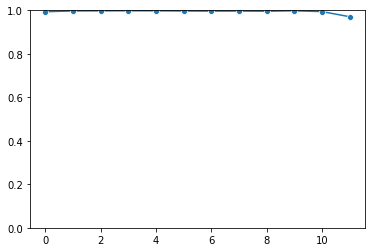

In [17]:
%%time

r = []
for j in range(num_layers):
    if j == 0:
        continue
    print(j)
    reps2 = np.array(datasets['ar'][f'mean_{j}'])
    np.random.shuffle(reps2)
    
    r.append(feature_space_linear_cka(np.array(datasets['en'][f'mean_{j}']), reps2, avg=False))
    
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

1
dot prod sim 6490202319904.0205
normalization_x 2545687.906345096 normalization_y 2549494.3519493854 mult 6490216939052.678
2
dot prod sim 12594946127928.613
normalization_x 3549458.866459616 normalization_y 3548415.5612082332 mult 12594955075613.838
3
dot prod sim 25516349245516.85
normalization_x 5057530.9127498 normalization_y 5045231.360043691 mult 25516413565395.68
4
dot prod sim 26651506541017.62
normalization_x 5208072.749961281 normalization_y 5117850.904827708 mult 26654139835797.875
5
dot prod sim 18468293573290.47
normalization_x 4413102.32682671 normalization_y 4186949.5308968397 mult 18477436717106.848
6
dot prod sim 19993438231333.56
normalization_x 4582380.70806084 normalization_y 4369577.172151164 mult 20023066136048.535
7
dot prod sim 20885700336569.434
normalization_x 4724817.070983354 normalization_y 4434822.941710202 mult 20953727141780.977
8
dot prod sim 30384819469496.938
normalization_x 5632532.409783156 normalization_y 5412768.2546356525 mult 30487592620880.72

(0.0, 1.0)

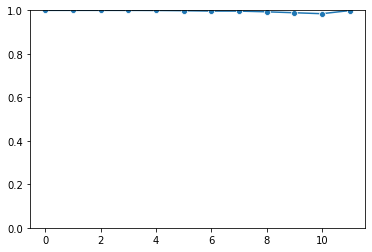

In [16]:
%%time

r = []
for j in range(num_layers):
    if j == 0:
        continue
    print(j)
    reps2 = np.array(datasets['ar'][f'cls_{j}'])
    np.random.shuffle(reps2)
    
    r.append(feature_space_linear_cka(np.array(datasets['en'][f'cls_{j}']), reps2, avg=False))
    
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 4min 5s, sys: 5.85 s, total: 4min 10s
Wall time: 3min 17s


(0.0, 1.0)

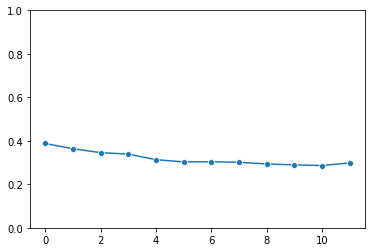

In [11]:
%%time

r = []
for j in range(num_layers):
    if j == 0:
        continue
    print(j)
    reps2 = np.array(datasets['ar'][f'cls_{j}'])
    np.random.shuffle(reps2)
    
    r.append(analysis.pwcca(np.array(datasets['en'][f'cls_{j}']).T, reps2.T))
    
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

(0.0, 1.0)

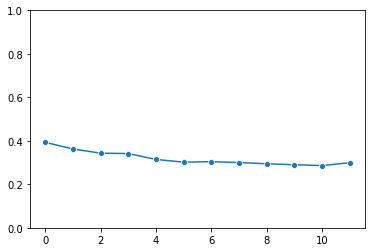

In [30]:
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 2min 40s, sys: 5.92 s, total: 2min 46s
Wall time: 2min 33s


(0.0, 1.0)

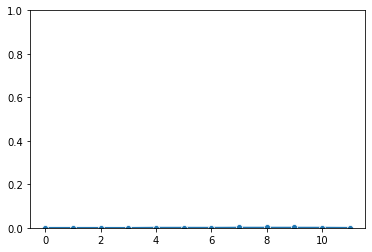

In [31]:
%%time

r = []
for j in range(num_layers):
    if j == 0:
        continue
    print(j)
    reps2 = np.array(datasets['ar'][f'cls_{j}'])
    np.random.shuffle(reps2)
    
    r.append(analysis.cka(np.array(datasets['en'][f'cls_{j}']).T, reps2.T))
    
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

In [84]:
r

[0.7791133232503115,
 0.8054282397709936,
 0.7848413078447403,
 0.7448861737851123,
 0.6480538800193152,
 0.6216873592128386,
 0.6068844606036023,
 0.5991472209706395,
 0.5944843905671022,
 0.5837459890693324,
 0.5895009034175067,
 0.6428495871649859]

In [ ]:
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

(0.0, 1.0)

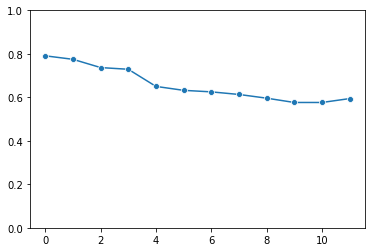

In [21]:
sns.lineplot(data=r, marker='o')
plt.ylim(0,1)

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
y

NameError: name 'y' is not defined

In [32]:
r # hyp

[0.6172094030606003,
 0.5854819510759801,
 0.6346019191827651,
 0.6631288710254764,
 0.7115577528346078,
 0.7418006302345395,
 0.7484686200765538,
 0.7119077178866541,
 0.7072865407820622,
 0.6774094473375084,
 0.6409690230967565,
 0.5699941907184463,
 0.5595081711785631]

In [22]:
%%time

cls_cka = defaultdict(list)
mean_cka = defaultdict(list)

for l in langs:
    if l == 'en':
        continue
    print(l)
    for j in range(num_layers):
        cls_cka[l].append(analysis.cka(np.array(datasets['en'][f'cls_{j}']).T, np.array(datasets[l][f'cls_{j}']).T))
        mean_cka[l].append(analysis.cka(np.array(datasets['en'][f'mean_{j}']).T, np.array(datasets[l][f'mean_{j}']).T))

ar


/gpfs/space/home/maksym95/.conda/envs/paper3/lib/python3.8/site-packages/ecco/svcca_lib/cka_lib.py:162: RuntimeWarning: invalid value encountered in double_scalars
  return dot_product_similarity / (normalization_x * normalization_y)


az


KeyboardInterrupt: 

In [11]:
num_layers = 13

def sts_spearman(reps1, reps2):
    res = []
    for s, t in zip(reps1, reps2):
        res.append(1 - spatial.distance.cosine(s, t))
    return stats.spearmanr(res, en_pivot['similarity_score']).correlation

In [11]:
from collections import defaultdict

In [12]:
%%time

cls_spearman = defaultdict(list)
mean_spearman = defaultdict(list)

for l in langs:
    print(l)
    for j in range(num_layers):
        cls_spearman[l].append(sts_spearman(en_pivot[f'cls_{j}'], datasets[l][f'cls_{j}']))
        mean_spearman[l].append(sts_spearman(en_pivot[f'mean_{j}'], datasets[l][f'mean_{j}']))

en


/gpfs/space/home/maksym95/.conda/envs/paper3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


de
es
fr
it
nl
pl
pt
ru
zh
CPU times: user 4min 36s, sys: 5.71 s, total: 4min 42s
Wall time: 4min 43s


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

(0.0, 0.8)

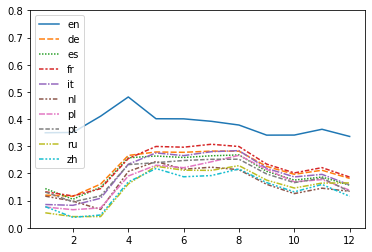

In [23]:
sns.lineplot(data=pd.DataFrame(cls_spearman))
plt.ylim(0, 0.8)

(0.0, 0.8)

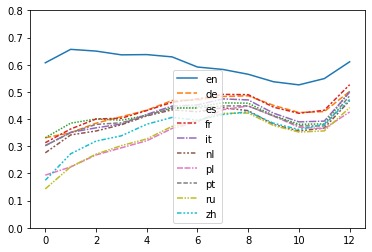

In [24]:
sns.lineplot(data=pd.DataFrame(mean_spearman))
plt.ylim(0, 0.8)

In [19]:
df_mean_spearman = pd.DataFrame(mean_spearman)
df_cls_spearman = pd.DataFrame(cls_spearman)

In [20]:
df_cls_spearman["cl avg"] = df_cls_spearman.loc[:, df_cls_spearman.columns != 'en'].mean(axis=1)
df_mean_spearman["cl avg"] = df_mean_spearman.loc[:, df_mean_spearman.columns != 'en'].mean(axis=1)

In [21]:
xling = {"xling_cls": df_cls_spearman["cl avg"], "xling_mean": df_mean_spearman["cl avg"]}
en = {"en_cls": df_cls_spearman["en"], "en_mean": df_mean_spearman["en"]}

In [27]:
list(range(13))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

<AxesSubplot:>

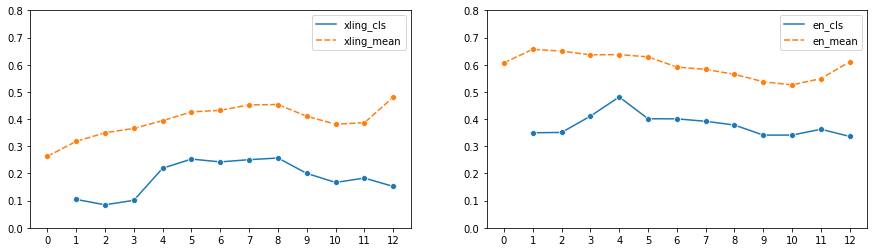

In [31]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

ax[0].set_ylim([0,0.8])
ax[0].set(xticks=list(range(13)))

ax[1].set_ylim([0,0.8])
ax[1].set(xticks=list(range(13)))

sns.lineplot(data=pd.DataFrame(xling), ax=ax[0], marker='o')
sns.lineplot(data=pd.DataFrame(en), ax=ax[1], marker='o')
